In [ ]:
# Installing H2O; uncomment of H2O is not installed
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# Installing H2O dependencies
# !pip install requests
# !pip install tabulate
# !pip install "colorama>=0.3.8"
# !pip install future

#uncomment of xgboost not installed
# !pip install xgboost

#uncomment if pydotplus not installed; dependency for graphviz
# !pip install pydotplus

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, SCORERS
from sklearn import ensemble

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from six import StringIO
from IPython.display import Image

import pydotplus
import graphviz



import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OTargetEncoderEstimator

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading Data

In [25]:
# Loading the dataset into pandas dataframe
train_df = pd.read_pickle("..\Data\interim\\train.pkl")
test_df = pd.read_pickle("..\Data\interim\\test.pkl")
validate_df = pd.read_pickle("..\Data\interim\\validate.pkl")
production_df = pd.read_pickle("..\Data\interim\\data.pkl")

In [26]:
X_train = train_df.drop("satisfaction",axis=1).copy()
y_train = train_df["satisfaction"].copy()
X_test = test_df.drop("satisfaction",axis=1).copy()
y_test = test_df["satisfaction"].copy()

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77928 entries, 103044 to 109671
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             77928 non-null  object 
 1   Customer Type                      77928 non-null  object 
 2   Age                                77928 non-null  int64  
 3   Type of Travel                     77928 non-null  object 
 4   Class                              77928 non-null  object 
 5   Flight Distance                    77928 non-null  int64  
 6   Seat comfort                       77928 non-null  int64  
 7   Departure/Arrival time convenient  77928 non-null  int64  
 8   Food and drink                     77928 non-null  int64  
 9   Gate location                      77928 non-null  int64  
 10  Inflight wifi service              77928 non-null  int64  
 11  Inflight entertainment             77928 non-nul

In [27]:
X_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
103044,Female,Loyal Customer,59,Business travel,Business,1470,4,4,4,4,...,4,4,4,4,4,5,4,3,7,0.0
43282,Female,disloyal Customer,22,Business travel,Eco,1771,1,1,1,4,...,5,4,3,4,3,1,4,4,0,0.0
65543,Male,Loyal Customer,55,Business travel,Business,3657,0,5,0,2,...,4,4,4,4,4,3,4,3,12,8.0
65083,Female,Loyal Customer,41,Business travel,Business,1796,0,4,0,1,...,5,3,3,3,3,5,3,3,0,0.0
76496,Male,Loyal Customer,42,Business travel,Eco,1709,2,3,3,3,...,2,2,4,4,4,1,3,2,0,0.0


# Checking for class-imbalance

satisfied       42630
dissatisfied    35298
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


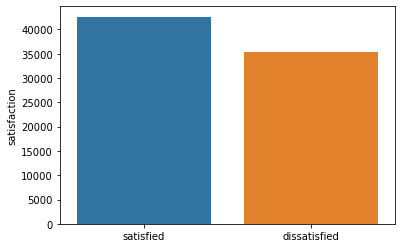

In [28]:
# train data check
x = y_train.value_counts()
print(x)
sns.barplot(x.index, x)

satisfied       14193
dissatisfied    11783
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


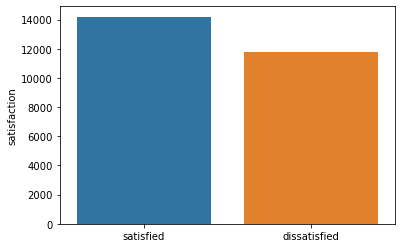

In [29]:
# test data check
x = y_test.value_counts()
print(x)
sns.barplot(x.index, x)

# Identifying Categorical & Numerical features

In [30]:
numerical_features = [x for x in X_train.select_dtypes(exclude = object)]
categorical_features = [x for x in X_train.select_dtypes(include = object)]

In [31]:
print("The numerical features of the dataset are:")
for _ in numerical_features: print(_)

The numerical features of the dataset are:
Age
Flight Distance
Seat comfort
Departure/Arrival time convenient
Food and drink
Gate location
Inflight wifi service
Inflight entertainment
Online support
Ease of Online booking
On-board service
Leg room service
Baggage handling
Checkin service
Cleanliness
Online boarding
Departure Delay in Minutes
Arrival Delay in Minutes


In [32]:
print("The categorical features of the dataset are:")
for _ in categorical_features: print(_)

The categorical features of the dataset are:
Gender
Customer Type
Type of Travel
Class


In [33]:
for f in categorical_features:
    print("\nThe unique labels in {} is {}".format(f, X_train[f].unique()))
    print("The values in {} is \n{}\n".format(f,  X_train[f].value_counts()))


The unique labels in Gender is ['Female' 'Male']
The values in Gender is 
Female    39461
Male      38467
Name: Gender, dtype: int64


The unique labels in Customer Type is ['Loyal Customer' 'disloyal Customer']
The values in Customer Type is 
Loyal Customer       63536
disloyal Customer    14392
Name: Customer Type, dtype: int64


The unique labels in Type of Travel is ['Business travel' 'Personal Travel']
The values in Type of Travel is 
Business travel    53815
Personal Travel    24113
Name: Type of Travel, dtype: int64


The unique labels in Class is ['Business' 'Eco' 'Eco Plus']
The values in Class is 
Business    37350
Eco         34981
Eco Plus     5597
Name: Class, dtype: int64



# Encode categorical variables

In [35]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# train_autoML = pd.DataFrame(ohe_encoder.fit_transform(X_train[categorical_features]), columns=ohe_encoder.get_feature_names_out, index=X_train.index)

In [ ]:
numeric_transformer = StandardScaler()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', ohe_encoder, categorical_features)
        ])

In [23]:
train_autoML.head()

AttributeError: head not found

In [21]:
ohe_encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['Loyal Customer', 'disloyal Customer'], dtype=object),
 array(['Business travel', 'Personal Travel'], dtype=object),
 array(['Business', 'Eco', 'Eco Plus'], dtype=object)]

In [ ]:
encoded_cat_names = list(ohe_encoder.get_feature_names(categorical_features))
encoded_cat_names

['Gender_Female',
 'Gender_Male',
 'Customer Type_Loyal Customer',
 'Customer Type_disloyal Customer',
 'Type of Travel_Business travel',
 'Type of Travel_Personal Travel',
 'Class_Business',
 'Class_Eco',
 'Class_Eco Plus']

# AutoML

In [37]:
## prepare data
h2o.init()

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements